## S 검증용 데이터를 활용한 S 함수 검증

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from scipy.io import loadmat

In [2]:
s_test_path = "/data/datasets/hyundai/20200812/s_test_data.mat"
s_test_mat = loadmat(s_test_path)

In [3]:
d = s_test_mat['d']
y = s_test_mat['y']
s_filter = s_test_mat['path_01']

y.shape, d.shape, s_filter.shape

((40000, 8), (40000, 8), (128, 8, 8))

## Pytorch 로 작성한 코드로 검증

In [4]:
y = torch.Tensor(y)
d = torch.Tensor(d)
s_filter = torch.Tensor(s_filter)

In [5]:
def conv_s(y, s_filter):
    # defined as a function
    ## New Conv S => Validated
    Ls, K, M = s_filter.shape
    Tn = y.shape[0]
    y_buffer = torch.zeros((Ls, K))
    y_p = torch.zeros(y.size())
    #e = torch.zeros(y.size())

    for n in range(Tn):
        for k in range(K):
            for m in range(M):
                #print(torch.matmul(y_buffer[:, k].unsqueeze(1).transpose(0,1), s_filter[:, k, m].unsqueeze(1)).shape)
                #y_p[n, m] += torch.mm(y_buffer[:, k].unsqueeze(1).transpose(0,1), s_filter[:, k, m].unsqueeze(1))[0,0]
                y_p[n,m] += torch.dot(y_buffer[:, k], s_filter[:, k, m])

        #e[n, :] = d[n, :] - y_p[n, :]
        y_buffer[1:, :] = y_buffer[:-1, :].clone()
        y_buffer[0, :] = y[n , :]
    return y_p

In [6]:
# defined as a function
## New Conv S => Validated
Ls, K, M = s_filter.shape
Tn = y.shape[0]
y_buffer = torch.zeros((Ls, K))
y_p = torch.zeros(y.size())
#e = torch.zeros(y.size())

for n in range(Tn):
    for k in range(K):
        for m in range(M):
            #print(torch.matmul(y_buffer[:, k].unsqueeze(1).transpose(0,1), s_filter[:, k, m].unsqueeze(1)).shape)
            #y_p[n, m] += torch.mm(y_buffer[:, k].unsqueeze(1).transpose(0,1), s_filter[:, k, m].unsqueeze(1))[0,0]
            y_p[n,m] += torch.dot(y_buffer[:, k], s_filter[:, k, m])

    #e[n, :] = d[n, :] - y_p[n, :]
    y_buffer[1:, :] = y_buffer[:-1, :].clone()
    y_buffer[0, :] = y[n , :]

In [15]:
for k in range(10):
    for i in range(8):
        print(f'[{y_p[k, i].item():.4f}]', end=' ')
    print("")

[0.0000] [0.0000] [0.0000] [0.0000] [0.0000] [0.0000] [0.0000] [0.0000] 
[0.0002] [0.0000] [-0.0002] [0.0009] [0.0006] [0.0005] [0.0010] [0.0015] 
[-0.0002] [-0.0003] [-0.0006] [0.0010] [0.0004] [0.0006] [0.0013] [0.0017] 
[-0.0010] [-0.0001] [-0.0008] [0.0006] [-0.0003] [0.0003] [0.0010] [0.0009] 
[-0.0018] [-0.0006] [-0.0009] [0.0002] [-0.0007] [-0.0001] [0.0002] [-0.0010] 
[-0.0020] [-0.0012] [-0.0008] [0.0002] [-0.0015] [-0.0001] [-0.0002] [-0.0028] 
[-0.0018] [-0.0007] [-0.0001] [0.0007] [-0.0009] [0.0007] [0.0005] [-0.0019] 
[-0.0021] [0.0009] [0.0013] [0.0036] [0.0007] [0.0025] [0.0027] [0.0009] 
[-0.0504] [0.0032] [0.0042] [0.0606] [0.0044] [0.0055] [0.0066] [0.0043] 
[-0.1865] [-0.0124] [0.0226] [0.1279] [0.0268] [0.0100] [0.0107] [-0.0438] 


In [16]:
y_p.shape, d.shape

(torch.Size([40000, 8]), torch.Size([40000, 8]))

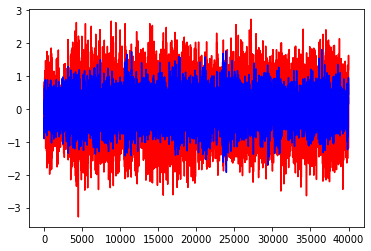

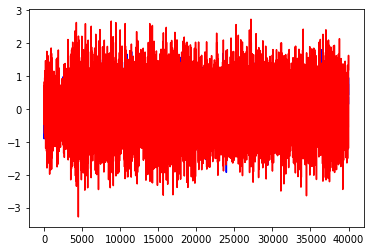

In [17]:
plt.plot(y_p[:,0], color='red')
plt.plot(d[:,0], color='blue')
plt.show()


plt.plot(d[:,0], color='blue')
plt.plot(y_p[:,0], color='red')
plt.show()

In [8]:
e = e.numpy()
y_p = y_p.numpy()
e.shape, y_p.shape

((40000, 8), (40000, 8))

In [9]:
y_prime = y_prime.numpy()
y_prime.shape

(40000, 8)

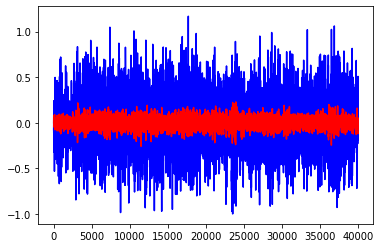

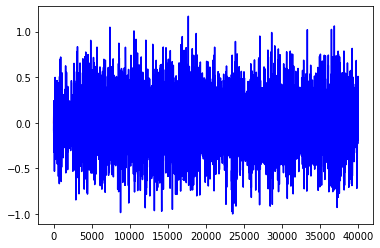

In [10]:
plt.plot(y_prime[:,0], color="blue")
plt.plot(y_p[:,-1], color="red")
plt.show()
plt.plot(y_p[:,-1], color="red")
plt.plot(y_prime[:,0], color="blue")
plt.show()

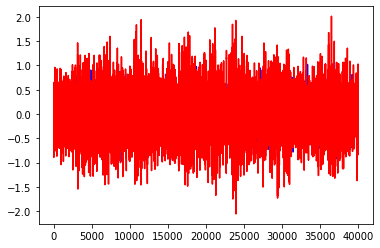

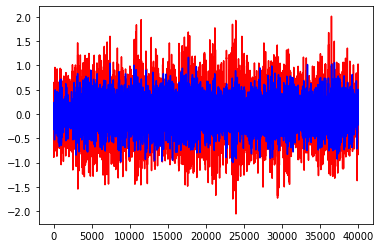

In [11]:
plt.plot(y_prime[:,0], color="blue")
plt.plot(e[:,0], color="red")
plt.show()
plt.plot(e[:,0], color="red")
plt.plot(y_prime[:,0], color="blue")
plt.show()

In [12]:
y_p[1]

array([-0.0036777 , -0.01204786, -0.013684  , -0.01360494,  0.01214635,
        0.01521921,  0.01700906,  0.02382452], dtype=float32)

In [4]:
M, K = 8, 8
Ls = 128
def Shift(y_buffer, k_idx, value):
    y_buffer[1:, k_idx] = y_buffer[:-1, k_idx]
    y_buffer[0, k_idx] = value
    return y_buffer

def Conv_S(signal, S_filter, device='cpu'):
    #Process S filter to waveform data
    #the shape of signal should be (batch, time, 8)
    batch_size = signal.size(0)
    time_len = signal.size(1)
    y_pred = torch.zeros((batch_size, time_len, M), device=device)
    #S_filter = torch.Tensor(S_data).to(device) #(Ls, K, M)
    Y_buffer = torch.zeros((Ls, K), device=device)
    for batch in range(batch_size):
        for n in range(time_len):
            for k in range(K):
                for m in range(M):
                    y_pred[batch, n, m] += torch.dot(Y_buffer[:, k], S_filter[:, k, m])
                    Y_buffer = Shift(Y_buffer, k, signal[batch, n, k])
        
    return y_pred

In [5]:
y_torch = torch.Tensor(y).unsqueeze(0)
s_filter= torch.Tensor(s_filter)
y_torch.shape, s_filter.shape

(torch.Size([1, 40000, 8]), torch.Size([128, 8, 8]))

In [6]:
y_pred = Conv_S(y_torch, s_filter)

In [7]:
y_pred = y_pred.squeeze(0).numpy()

In [8]:
y_pred.shape

(40000, 8)

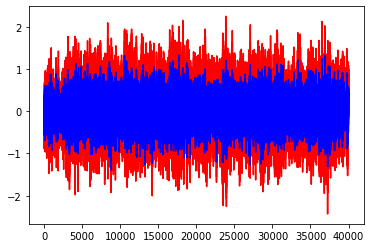

In [11]:
plt.plot(y - y_pred, color="red")
plt.plot(y_prime, color="blue")
plt.show()

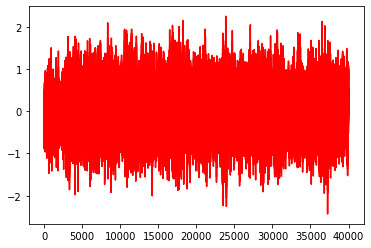

In [12]:
plt.plot(y_prime, color="blue")
plt.plot(y - y_pred, color="red")
plt.show()